In [67]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm, trange
import time

from torchvision.models import resnet50
from facenet_pytorch import InceptionResnetV1
from collections import OrderedDict

In [2]:
def get_ratio_bbox_and_image(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_h, real_w, _ = img.shape
    area_image = real_h * real_w
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    area_bbox = w1*h1
    return area_bbox / area_image


def standard_width_height_scaling(real_w, real_h, bbox0, bbox1, bbox2, bbox3):
    x1 = int(int(bbox0)*(float(real_w) / 224)) # bbox[0]
    y1 = int(int(bbox1)*(float(real_h) / 224)) # bbox[1]
    w1 = int(int(bbox2)*(float(real_w) / 224)) # bbox[2]
    h1 = int(int(bbox3)*(float(real_h) / 224)) # bbox[3]
    return x1, y1, w1, h1


def get_area_bbox_indices(bound_box_path, real_w, real_h):
    bound_box_read = open(bound_box_path, "r")
    bound_box_indices = list()
    for i in bound_box_read:
        bound_box_indices.append(i)
    bbox = bound_box_indices[0].split()
    x1, y1, w1, h1 = standard_width_height_scaling(real_w, real_h, 
                                                   bbox[0], bbox[1], bbox[2], bbox[3])
    return x1, y1, w1, h1

def get_padding_bbox_indices(x1, y1, w1, h1, real_w, real_h, ratio_bbox_and_image):
    x1_padding = x1 - int((w1) * (1+ratio_bbox_and_image))
    y1_padding = y1 - int((h1) * (1+ratio_bbox_and_image))
    w1_padding = w1 + int((w1) * (1+ratio_bbox_and_image))
    h1_padding = h1 + int((h1) * (1+ratio_bbox_and_image))
    if x1_padding < 0: 
        x1_padding = 0
    if y1_padding < 0:
        y1_padding = 0
    if w1_padding > real_w:
        w1_padding = real_w
    if h1_padding > real_h:
        h1_padding = real_h
    return x1_padding, y1_padding, w1_padding, h1_padding
    
def read_crop_img_with_bbox(full_img_path, bound_box_path):
    img = cv2.imread(full_img_path)
    real_w = img.shape[1]
    real_h = img.shape[0]
    x1, y1, w1, h1 = get_area_bbox_indices(bound_box_path, real_w, real_h)
    return x1, y1, w1, h1, img, real_w, real_h

In [3]:
# Live Storage
original_cropped_storage = []
padding_cropped_storage = []
img_names = []
original_cropped_labels = []
padding_cropped_labels = []

count_live = 0
count_spoof = 0
dim = (160, 160)
count_limit_live = 10000
count_limit_spoof = 10000

rootdir_train = 'D:/Datasets/Celeba_Spoof/Data/test'
for file in os.listdir(rootdir_train):
    d = rootdir_train + '/' + file
    if os.path.isdir(d):
        for e in os.listdir(d):
            imgs_path = d + '/' + e + '/'
            for img_path in os.listdir(imgs_path):
                full_img_path = imgs_path + img_path
                if (img_path.endswith(".png") and cv2.imread(full_img_path) is not None):
                    bound_box_path = full_img_path[0:-4] + '_BB.txt'
                    x1, y1, w1, h1, img, real_w, real_h = read_crop_img_with_bbox(full_img_path, bound_box_path)
                    ratio_bbox_and_image = get_ratio_bbox_and_image(full_img_path, bound_box_path)
                    x1_padding, y1_padding, w1_padding, h1_padding = get_padding_bbox_indices(x1, y1, w1, h1, 
                                                                                              real_w, real_h,
                                                                                              ratio_bbox_and_image)
                    padding_img = img[y1_padding:y1+h1_padding, x1_padding:x1+w1_padding]
                    try:
                        if (e == 'live' and count_live >= count_limit_live) or (e == 'spoof' and count_spoof >= count_limit_spoof):
                            continue
                        resized_padding_img = cv2.resize(padding_img, dim, interpolation = cv2.INTER_AREA)
                        padding_cropped_storage.append(resized_padding_img)
                        if e == 'live':
                            count_live = count_live + 1
                            padding_cropped_labels.append(1)
                        elif e == 'spoof':
                            count_spoof = count_spoof + 1
                            padding_cropped_labels.append(0)
                    except:
                        continue
                    img_names.append(img_path)
                    if (count_live == count_limit_live and e == 'live') or (count_spoof == count_limit_spoof and e == 'spoof'):
                        break
            if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
                break
    if count_live >= count_limit_live and count_spoof >= count_limit_spoof:
        print("DONE Extracting ")
        break

In [4]:
X = np.asarray(padding_cropped_storage)
y = np.asarray(padding_cropped_labels)
np.savez('anti_spoofing_data.npz', X, y)
print("DONE SAVING DATA WITH NPZ")

DONE SAVING DATA WITH NPZ


In [5]:
anti_spoofing_data = np.load('anti_spoofing_data.npz')
X, y = anti_spoofing_data['arr_0'], anti_spoofing_data['arr_1']
temp = set(y)
check_live_label = 0
check_spoof_label = 0
for i in y: 
    if i == 1:
        check_live_label += 1
    elif i == 0:
        check_spoof_label += 1
print(f"There are 2 classes including number of live is {check_live_label} and number of spoof is {check_spoof_label}")

There are 2 classes including number of live is 8525 and number of spoof is 10000


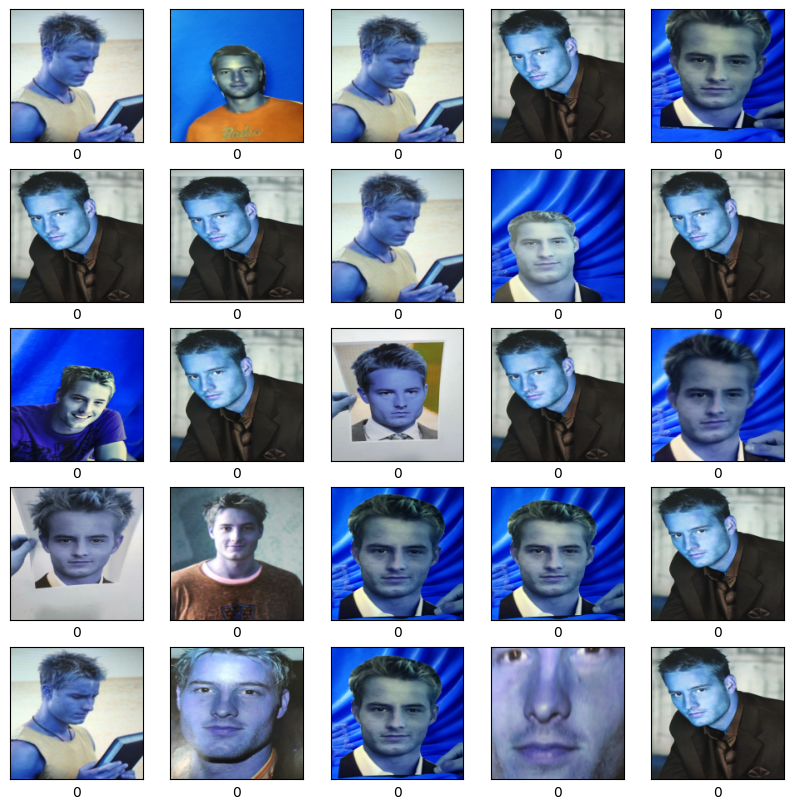

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i + 5000])
    plt.xlabel(y[i + 5000])
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

In [9]:
class celebADataset(Dataset):
    def __init__(self, X, y, transform, aug=None):
        self.images = X
        self.labels = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):        
        image = self.images[idx]
        label = self.labels[idx]
        sample = {
            'image': image,
            'label': label,
        }
        sample['image'] = self.transform(sample['image'])
        return sample

In [38]:
transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize(160),
      #transforms.CenterCrop(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [11]:
train_data = celebADataset(X_train, y_train, transform)
val_data = celebADataset(X_valid, y_valid, transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [12]:
InceptionResnetV1(pretrained='vggface2')

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [14]:
import torch
from torch import nn
from torchvision.models import resnet50
from facenet_pytorch import InceptionResnetV1

device = 'cuda'

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 2))

    def forward(self, x):
        x = x.to(device)
        x = self.resnet(x)
        x = self.classifier(x)
        return x
    
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, (3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 64, (3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(20736, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 2)
)

    def forward(self, x):
        x = x.to(device)
        x = self.model(x)
        return x
    
class Model_4(nn.Module):
    def __init__(self):
        super(Model_4, self).__init__()
        

    def forward(self, x):
        
        return x
    #resnet18 + simple_model + features

In [15]:
def evaluate(model, dataloader, loss_fn):
    losses = []
    num_correct = 0
    num_elements = 0
    for batch in tqdm(dataloader, leave=False):
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            y_pred = torch.argmax(logits, dim=1)
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    accuracy = num_correct / num_elements 
    return accuracy.numpy(), np.mean(losses)

In [16]:
def train_model(model, train_dl, val_dl, loss_fn, optimizer, epochs = 10):
    model.train()
    torch.cuda.empty_cache()
    running_loss = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    num_correct = 0
    num_elements = 0
    for epoch in range(epochs):
        model.train()
        num_correct = 0
        num_elements = 0
        running_loss = 0
        for batch in tqdm(train_dl, leave=False, desc=f"epoch:{epoch}"):
            optimizer.zero_grad()
            X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            num_correct += torch.sum(preds == y_batch.data)
            num_elements += X_batch.size(0)
        model.eval()
        train_losses.append(running_loss / num_elements)
        train_accs.append(num_correct.cpu().numpy() / num_elements)
        print(f'epoch:{epoch} train_acc: {train_accs[-1]}')
        val_acc, val_loss = evaluate(model, val_dl, loss_fn)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        print(f'epoch:{epoch} val_acc: {val_accs[-1]}')
    return model, train_accs, train_losses, val_accs, val_losses

In [17]:
loss_fn = nn.CrossEntropyLoss()
model = Model_2().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [60]:
model, train_accs, train_losses, val_accs, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, 1)

epoch:0:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:0 train_acc: 0.9961440579933678


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:0 val_acc: 0.9771500825881958


In [64]:
loss_fn = nn.CrossEntropyLoss()
model_2 = Model_1().to(device)
optimizer = torch.optim.Adam(model_2.classifier.parameters(), lr = 1e-3)

In [65]:
model_2, train_accs, train_losses, val_accs, val_losses = train_model(model_2, train_loader, val_loader, loss_fn, optimizer, 10)

epoch:0:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:0 train_acc: 0.7543764941775276


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:0 val_acc: 0.7401943206787109


epoch:1:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:1 train_acc: 0.7929359142438498


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:1 val_acc: 0.8119827508926392


epoch:2:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:2 train_acc: 0.8105961286342254


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:2 val_acc: 0.8164807558059692


epoch:3:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:3 train_acc: 0.8153003778823167


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:3 val_acc: 0.753688395023346


epoch:4:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:4 train_acc: 0.8199275082902753


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:4 val_acc: 0.756207287311554


epoch:5:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:5 train_acc: 0.8314182154700394


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:5 val_acc: 0.8035264611244202


epoch:6:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:6 train_acc: 0.8361995835582633


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:6 val_acc: 0.8387909531593323


epoch:7:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:7 train_acc: 0.8369707719595897


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:7 val_acc: 0.8479669094085693


epoch:8:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:8 train_acc: 0.8387445052826406


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:8 val_acc: 0.776358425617218


epoch:9:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:9 train_acc: 0.839515693683967


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:9 val_acc: 0.8404102325439453


In [68]:
model_3 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='ResNet18_Weights.IMAGENET1K_V1')
model_3.fc = nn.Sequential(OrderedDict([
          ('l1', nn.Linear(512, 512)),
          ('bn', nn.BatchNorm1d(512)),
          ('sigma', nn.Sigmoid()),
          ('l2', nn.Linear(512, 2))
        ]))

model_3.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.fc.parameters(), lr = 1e-3)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\savel/.cache\torch\hub\v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\savel/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:06<00:00, 7.20MB/s]


In [70]:
model_3, train_accs, train_losses, val_accs, val_losses = train_model(model_3, train_loader, val_loader, loss_fn, optimizer, 3)

epoch:0:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:0 train_acc: 0.920413356983111


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:0 val_acc: 0.9346887469291687


epoch:1:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:1 train_acc: 0.9282794786766407


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:1 val_acc: 0.9174163341522217


epoch:2:   0%|          | 0/406 [00:00<?, ?it/s]

epoch:2 train_acc: 0.9339091540063238


  0%|          | 0/174 [00:00<?, ?it/s]

epoch:2 val_acc: 0.9417056441307068


In [48]:
imgs = []
labls = []
rootdir_train = 'D:/Frames/'
i = 0
for file in os.listdir(rootdir_train):
    imgs.append(cv2.resize(cv2.imread(rootdir_train + file), (160, 160)))
    if (i < 18):
        labls.append(1)
    else:
        labls.append(0)

In [49]:
test_data = celebADataset(imgs, labls, transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [50]:
test_data[0]['image'].shape

torch.Size([3, 160, 160])

In [51]:
evaluate(model, test_loader, loss_fn)

  0%|          | 0/1 [00:00<?, ?it/s]

(array(0.46875, dtype=float32), 1.6457477807998657)

In [56]:
def test(model, dataloader, loss_fn):
    losses = []
    num_correct = 0
    num_elements = 0
    for batch in tqdm(dataloader, leave=False):
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        with torch.no_grad():
            logits = model(X_batch.to(device))
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            y_pred = torch.argmax(logits, dim=1)
            num_correct += torch.sum(y_pred.cpu() == y_batch)
            plt.figure(figsize=(10,10))
            for i in range(25):
                plt.subplot(5,5,i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(batch['image'][i].permute(1, 2, 0).numpy())
                plt.xlabel(y_pred[i].cpu().numpy())
            plt.show()
    accuracy = num_correct / num_elements 
    return accuracy.numpy(), np.mean(losses)

  0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

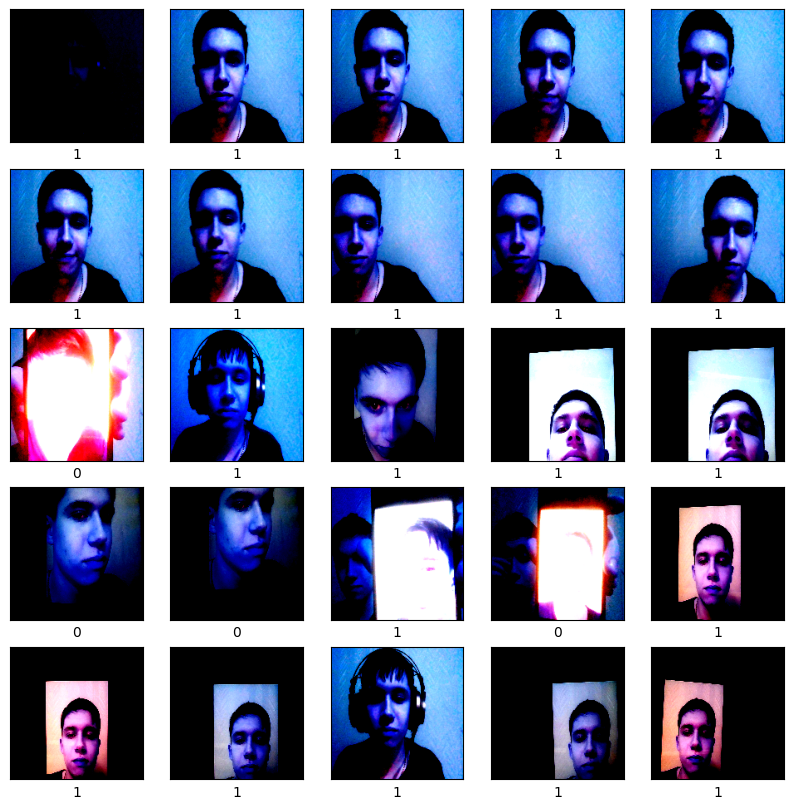

(array(0.84375, dtype=float32), 0.2302614152431488)

In [71]:
test(model_3, test_loader, loss_fn)